In [8]:
import cloudpickle as pickle
import sys


# sys.path.append("/home/luliqiang/python-cnn-tools-test/QuCT-Micro2023")

from openpyxl import Workbook
from downstream.fidelity_predict.evaluate_tools import plot_top_ratio
from plot.plot import get_duration2circuit_infos
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
from circuit.parser import get_circuit_duration, get_couple_prop
from circuit.utils import make_circuitlet
# from generate_dataset import gen_train_dataset
from plot.plot import plot_duration_fidelity, plot_top_ratio, find_error_path, plot_correlation, plot_real_predicted_fidelity
import random
import numpy as np
import ray
# from circuit import gen_random_circuits, label_ground_truth_fidelity
from upstream import RandomwalkModel
from downstream import FidelityModel
from simulator import NoiseSimulator, get_random_erroneous_pattern
from utils.backend import devide_chip, gen_grid_topology, get_grid_neighbor_info, Backend, topology_to_coupling_map
from utils.backend import default_basis_single_gates, default_basis_two_gates
import pickle
import os
from sklearn.model_selection import train_test_split
from scipy import io as sio

In [10]:

with open(f"execute_18bit/step2/error_params_predicts_execute_18bits_train_0_2500_step2.pkl", "rb")as f:
    downstream_model, predicts, reals, durations, test_dataset = pickle.load(f)
upstream_model = downstream_model.upstream_model


print('average inaccuracy = ', np.abs(predicts - reals).mean())
print('average inaccuracy = ', np.abs(predicts - reals).std())

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


average inaccuracy =  0.057801282711188
average inaccuracy =  0.04696463281316366


In [14]:
test_dataset[1000]['num_qubits']

5

In [2]:
with open('execute_18bit/step2/error_params_predicts_execute_18bits_train_0_2500_step2.pkl',  'rb') as f:
    downstream_model, predicts, reals, props, test_dataset = pickle.load(f)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [69]:
len(reals),len(test_dataset)

(1500, 1500)

In [65]:
with open('execute_18bit/devide_index.pkl',  'rb') as f:
    train_index, test_index = pickle.load(f)


In [3]:
error_params =  downstream_model.error_params['gate_params']
upstream_model = downstream_model.upstream_model

In [4]:
upstream_model.travel_directions

In [68]:
for device, table in upstream_model.device2path_table.items():
    print(device, len(table))

0 12998
1 13416
2 14445
3 13732
4 14221
5 14325
6 12985
7 12935
8 13163
9 15835
10 14188
11 14515
12 13221
13 14728
14 14994
15 16990
16 15891
17 13883
(6, 12) 4446
(3, 4) 2613
(16, 17) 2443
(12, 13) 3248
(2, 8) 3860
(11, 17) 4759
(13, 14) 4690
(7, 13) 3268
(4, 5) 3208
(3, 9) 2625
(14, 15) 3041
(0, 1) 3851
(1, 2) 4712
(10, 11) 4816
(6, 7) 4553
(15, 16) 4589
(4, 10) 3118
(5, 11) 4750
(0, 6) 2661
(2, 3) 4639
(9, 15) 4558
(10, 16) 2393
(7, 8) 2386


In [30]:
error_params = np.array(error_params)

device_index2device = {} #两比特门与但单比特门映射为一维下标
for device  in upstream_model.device2path_table.keys():
    device_index = list(upstream_model.device2path_table.keys()).index(device)
    device_index2device[device_index] = device

filter_path = {}
filter_path_weight = []
    
error_params_path_weight = {} #训练好的参数对应的path及其权重
error_params_path = {}
for idx, device_error_param in enumerate(error_params):
    device = device_index2device[idx]
    sort = np.argsort(device_error_param)
    sort = sort[::-1]
    device_error_params_path_weight = []
    device_error_params_path = []
    
    device_filter_path = [] 
    for i in sort:
        if int(i) in upstream_model.device2reverse_path_table[device].keys():
            path = upstream_model.device2reverse_path_table[device][int(i)]
            if isinstance(path,str):
                device_error_params_path_weight.append((path,device_error_param[i]))
                device_error_params_path.append(path)
                
                if device_error_param[i] < 0.1:
                    filter_path_weight.append((path,device_error_param[i]))
                    device_filter_path.append(path)
                
    error_params_path_weight[device] = device_error_params_path_weight
    error_params_path[device] = device_error_params_path
    filter_path[device] = device_filter_path


In [36]:
sum([len(filter_path[key]) for key in filter_path.keys()])

191902

In [37]:
with open('execute_18bit/step2_finetune/filter_path.pkl',  'wb') as f:
    pickle.dump(filter_path, f)

In [24]:
filter_path

['rz,0-parallel-rz,3-former-ry,0',
 'rx,0-parallel-cz,7,13-former-ry,17',
 'rx,0-parallel-ry,14-former-ry,12',
 'rz,0-parallel-rx,12-parallel-ry,14',
 'rz,0-parallel-cz,7,13-former-ry,13',
 'ry,0-parallel-rx,13-parallel-cz,6,7',
 'rx,0-parallel-ry,13-parallel-rx,14',
 'rz,0-parallel-rz,8-parallel-rz,11',
 'rz,0-parallel-rz,7-former-cz,1,2',
 'rx,0-parallel-ry,7-parallel-rz,11',
 'rz,0-parallel-cz,6,12-former-ry,2',
 'rz,0-parallel-cz,13,14-parallel-rz,6',
 'ry,0-parallel-ry,2-parallel-rx,13',
 'rz,0-parallel-cz,7,8-parallel-rx,11',
 'rx,0-parallel-rz,12-parallel-ry,14',
 'rz,0-parallel-cz,6,7-former-rz,10',
 'rx,0-parallel-cz,2,3-former-ry,2',
 'ry,0-parallel-ry,12-former-rx,4',
 'rx,0-parallel-ry,15-former-rz,15',
 'rx,0-parallel-rz,2-parallel-ry,3',
 'ry,0-parallel-cz,2,3-parallel-cz,10,11',
 'rx,0-parallel-cz,7,8-former-cz,14,15',
 'rz,0-parallel-rz,7-former-ry,12',
 'rz,0-parallel-cz,2,3-former-rx,0',
 'rx,0-parallel-rz,1-former-rx,11',
 'rx,0-parallel-cz,6,12-parallel-cz,3,9',
 'r

In [22]:
len(filter_path_weight) /41


4680.536585365854

In [2]:
with open("execute_18bit/step2_finetune/cut_dataset.pkl","rb") as f:
    cut_dataset = pickle.load(f)

In [3]:
depth = []
for cir in cut_dataset:
    depth.append(len(cir['layer2gates']))

In [4]:
depth = np.array(depth)
depth.min(), depth.max()

(4, 162)

<AxesSubplot: >

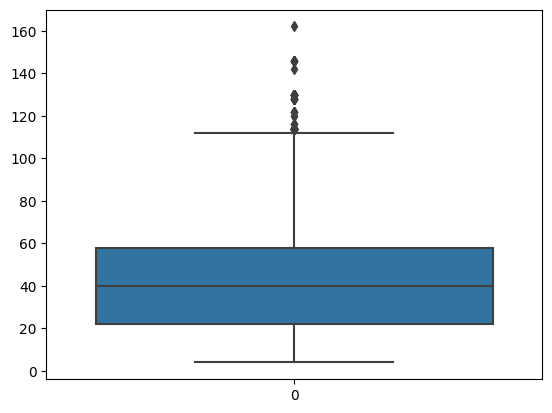

In [5]:
import seaborn as sns
sns.boxplot(depth)